In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm
import string
from analysis import *

# Load and prepare data

In [2]:
# Load data
X_es = []
spikes = []
for i in range(140, 140 + seeds_num_1):
    data = load_data("./data/seqlearn_cue0_v4_seed{}.pickle".format(i))
    X_es.append(data["X_e"])
    spikes.append(data["spikes"])

In [3]:
# Helper function to compute transition probabilities
def transition_prob(X_es, spikes, start_time):
    trans_prob = np.zeros((len(X_es), clu_num, clu_num))
    for i in tqdm(range(len(X_es))):
        clu_neurs = get_cluster_neurons(X_es[i])
        spikes_dic = spikes[i]
        firing_idxs = []
        for clu in range(clu_num):
            spikes_clu = np.concatenate([spikes_dic[neur] for neur in clu_neurs[clu]]) * second
            spikes_clu = spikes_clu[(start_time < spikes_clu) & (spikes_clu <= start_time + test_time)]
            times = np.linspace(start_time, start_time + test_time, int(test_time/rate_dt)+1)
            rates = np.sum([1/2 * gaussian(s_i, times, tau) for s_i in spikes_clu], 0) / len(clu_neurs[clu])
            firing_idxs.append(argrelmax(rates)[0])
        firing_order = []
        for t_idx in range(int(test_time/rate_dt)+1):
            for clu in range(clu_num):
                if np.any(firing_idxs[clu]==t_idx):
                    firing_order.append(clu)
        for clu_a in range(clu_num):
            for clu_b in range(clu_num):
                trans_prob[i, clu_a, clu_b] = np.sum([firing_order[j:j+2]==[clu_a, clu_b] for j in range(len(firing_order))])
                trans_prob[i, clu_a, clu_b] /= firing_order.count(clu_a)                           
    return 100*trans_prob.T

In [4]:
# Get transition probabilities
af_time = growth_time + test_time + 2*relax_time + learn_time
trans_prob_bf = transition_prob(X_es, spikes, growth_time)
trans_prob_af = transition_prob(X_es, spikes, af_time)

In [7]:
# Compute transition probabilities in forward and backward direction
trans_prob_diff = trans_prob_af-trans_prob_bf
trans_prob_fw = np.mean([trans_prob_diff[clu+1, clu] for clu in range(clu_num-1)], 0)
trans_prob_bw = np.mean([trans_prob_diff[clu, clu+1] for clu in range(clu_num-1)], 0)

# Figure

In [12]:
# Helper function to plot transition probabilities
def plot_trans_prob(ax, W, cmap, cbar_label="Trans. prob. [%]"):
    im = ax.imshow(W, cmap=cmap)
    plt.colorbar(im, ax=ax, label=cbar_label)
    ax.set_xticks(np.arange(clu_num))
    ax.set_yticks(np.arange(clu_num))
    ax.set_xticklabels(string.ascii_uppercase[:8])
    ax.set_yticklabels(string.ascii_uppercase[:8]) 
    ax.set_xlabel("From")
    ax.set_ylabel("To")

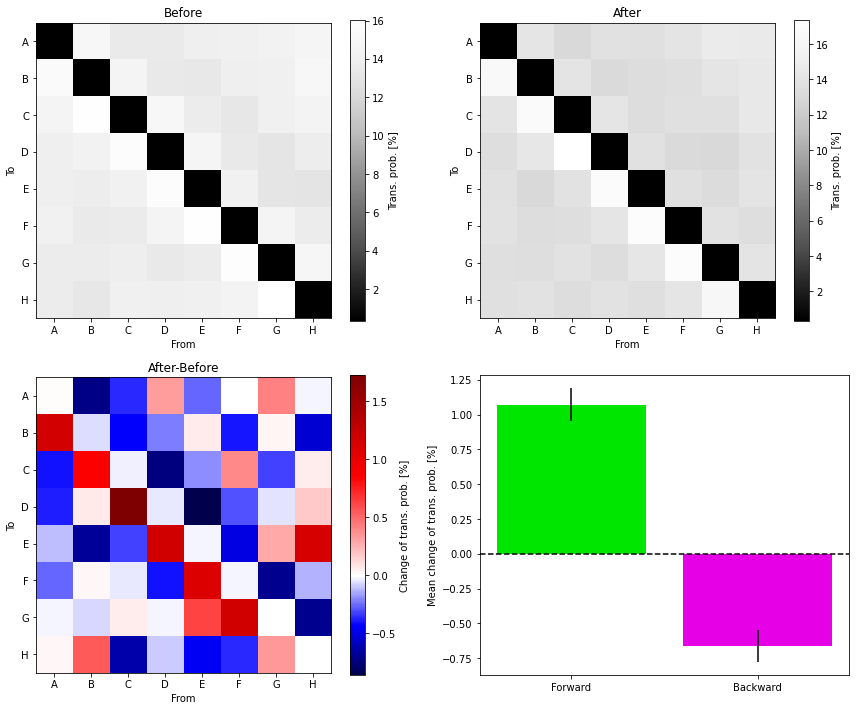

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Panel A
ax = axs[0, 0]
plot_trans_prob(ax, trans_prob_bf.mean(-1), plt.get_cmap('Greys_r'))
ax.set_title("Before")

# Panel B
ax = axs[0, 1]
plot_trans_prob(ax, trans_prob_af.mean(-1), plt.get_cmap('Greys_r'))
ax.set_title("After")

# Panel C
ax = axs[1, 0]
trans_prob_diff = (trans_prob_af-trans_prob_bf).mean(-1)
midpoint = -trans_prob_diff.min()/(trans_prob_diff.max()-trans_prob_diff.min())
plot_trans_prob(ax, trans_prob_diff, shiftedColorMap(plt.get_cmap('seismic'), midpoint=midpoint), "Change of trans. prob. [%]")
ax.set_title("After-Before")

# Panel D
ax = axs[1, 1]
ax.bar(0, trans_prob_fw.mean(-1), yerr=stats.sem(trans_prob_fw), color=(0, 0.9, 0))
ax.bar(1, trans_prob_bw.mean(-1), yerr=stats.sem(trans_prob_bw), color=(0.9, 0.0, 0.9))
ax.axhline(0, color='k', ls='--')
ax.set_xticks([0, 1])
ax.set_xticklabels(["Forward", "Backward"])
ax.set_ylabel("Mean change of trans. prob. [%]")


fig.tight_layout()
plt.show()